# Este projeto também está disponível localmente e no GITHUB

## Diretório do projeto e link do GITHUB

- 'C:/Users/miche/Desktop/CAPSTONE/insper0924'
- [Capstone_Outlier_Fcst](https://github.com/mconjaud/Capstone.git)



### Bibliotecas utilizadas


In [25]:
#Instalações necessárias
#!pip install sktime

In [42]:
df.head()

,Unnamed: 0,id,dataReferencia,codigo,nome,repacVenc,indice,correcao,taxaCompra,taxaVenda,...,percPu,duration,percReune,referenciaNTNB,spread_bid_ask,spread,spread_2,taxaIndicativa_diff,AnoTrimestre,month
0,716355,1584417,2023-07-03,ALGA28,ALGAR TELECOM S/A,2026-02-15,0.9,di_spread,1.7257,1.3677,...,"98,76","463,66",0,1900-01-01,0.3580,-1.2278,-0.5420,-0.0271,2023Q3,2023-07-01
1,717139,1585985,2023-07-04,ALGA28,ALGAR TELECOM S/A,2026-02-15,0.9,di_spread,1.6921,1.4228,...,"98,79","462,49",0,1900-01-01,0.2693,-1.2990,-0.6307,-0.0175,2023Q3,2023-07-01
2,717923,1587550,2023-07-05,ALGA28,ALGAR TELECOM S/A,2026-02-15,0.9,di_spread,1.7384,1.4434,...,"98,81","461,29",0,1900-01-01,0.2950,-1.2691,-0.6050,-0.0042,2023Q3,2023-07-01
3,718704,1589112,2023-07-06,ALGA28,ALGAR TELECOM S/A,2026-02-15,0.9,di_spread,1.7119,1.3991,...,"98,81","460,08",0,1900-01-01,0.3128,-1.2528,-0.5872,0.0015,2023Q3,2023-07-01
4,719485,1590673,2023-07-07,ALGA28,ALGAR TELECOM S/A,2026-02-15,0.9,di_spread,1.7125,1.3973,...,"98,82","459,46",0,1900-01-01,0.3152,-1.2448,-0.5848,-0.0056,2023Q3,2023-07-01


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import linregress
from numpy.polynomial.polynomial import Polynomial
from prophet import Prophet
from darts.models import (
    NaiveSeasonal,
    NaiveDrift,
    Prophet,
    ExponentialSmoothing,
    ARIMA,
    AutoARIMA,
    TBATS,
    StatsForecastAutoARIMA
)
from darts import TimeSeries
import sktime as sk
import os
from scipy.signal import detrend


### Codigo do Ativo Analisado




## Carregar o dataset e fazer conversões


In [26]:
# Carregando os datasets para inspecionar a estrutura
files = {
    "ALGA_MBM_2023Q3": "series_trimestrais/ALGA_MBM_2023Q3.csv",
    "ALGA_MBM_2024Q3": "series_trimestrais/ALGA_MBM_2024Q3.csv",
    "CSAN232024Q3": "series_trimestrais/CSAN232024Q3.csv",
    "CTEE192024Q3": "series_trimestrais/CTEE192024Q3.csv"
}

# Carregar todos os arquivos em um dicionário de DataFrames
dataframes = {name: pd.read_csv(path) for name, path in files.items()}

# Verificando as primeiras linhas de cada arquivo para avaliar a presença de 'taxaIndicativa_diff'
sample_data = {name: df.head() for name, df in dataframes.items()}
sample_data

# Filtrar apenas os datasets que possuem a coluna 'taxaIndicativa_diff'
filtered_dataframes = {name: df for name, df in dataframes.items() if 'taxaIndicativa_diff' in df.columns}



### Realizar os testes para saber se as variaveis taxaIndicativa, Spread, Spread2, Spread_bid_ask são estacionárias para os 4 datasets

In [19]:
# Função para realizar o teste ADF
def test_stationarity(series):
    result = adfuller(series.dropna())
    return {'ADF Statistic': result[0], 'p-value': result[1], 'Is Stationary': result[1] < 0.05}

dataframes = {name: pd.read_csv(path) for name, path in files.items()}

# Variáveis a serem testadas
variables = ['taxaIndicativa', 'spread', 'spread_2', 'spread_bid_ask', 'taxaIndicativa_diff']

# Aplicar o teste ADF
stationarity_results = {}

for name, df in dataframes.items():
    stationarity_results[name] = {}
    for var in variables:
        if var in df.columns:
            stationarity_results[name][var] = test_stationarity(df[var])

# Exibir os resultados
for dataset, results in stationarity_results.items():
    print(f"\nResultados do Teste ADF - {dataset}")
    for variable, result in results.items():
        print(f"{variable}: ADF Statistic = {result['ADF Statistic']:.4f}, p-value = {result['p-value']:.4f}, Stationary = {result['Is Stationary']}")



Resultados do Teste ADF - ALGA_MBM_2023Q3
taxaIndicativa: ADF Statistic = -0.8114, p-value = 0.8157, Stationary = False
spread: ADF Statistic = -0.8573, p-value = 0.8017, Stationary = False
spread_2: ADF Statistic = -3.4460, p-value = 0.0095, Stationary = True
spread_bid_ask: ADF Statistic = -3.4460, p-value = 0.0095, Stationary = True
taxaIndicativa_diff: ADF Statistic = -6.5535, p-value = 0.0000, Stationary = True

Resultados do Teste ADF - ALGA_MBM_2024Q3
taxaIndicativa: ADF Statistic = -1.3194, p-value = 0.6202, Stationary = False
spread: ADF Statistic = -2.5501, p-value = 0.1038, Stationary = False
spread_2: ADF Statistic = -1.5809, p-value = 0.4932, Stationary = False
spread_bid_ask: ADF Statistic = -1.5809, p-value = 0.4932, Stationary = False
taxaIndicativa_diff: ADF Statistic = -8.0544, p-value = 0.0000, Stationary = True

Resultados do Teste ADF - CSAN232024Q3
taxaIndicativa: ADF Statistic = -1.1890, p-value = 0.6783, Stationary = False
spread: ADF Statistic = -0.9826, p-val

## Realizar a Regressão Linear dos 4 Datasets

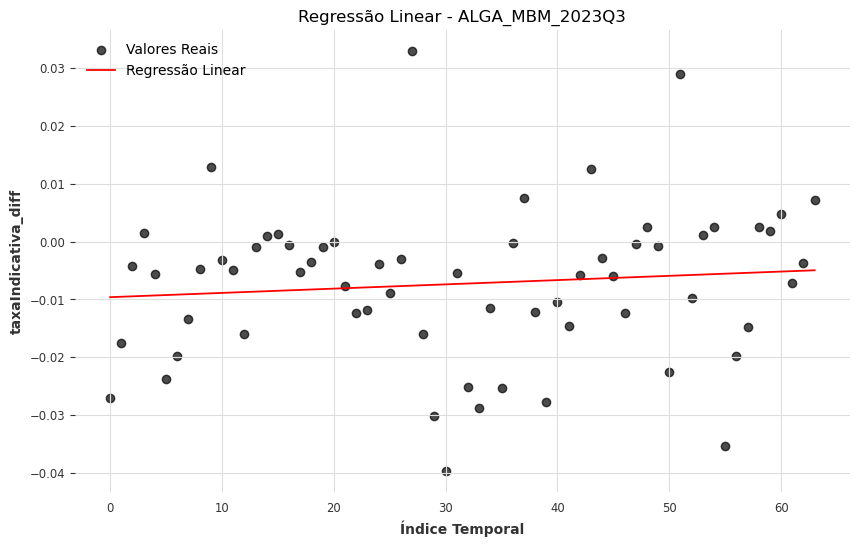

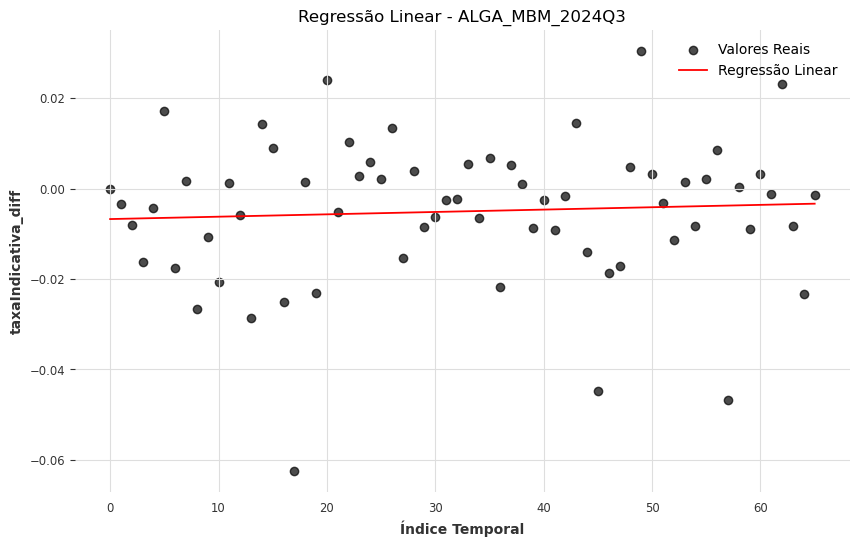

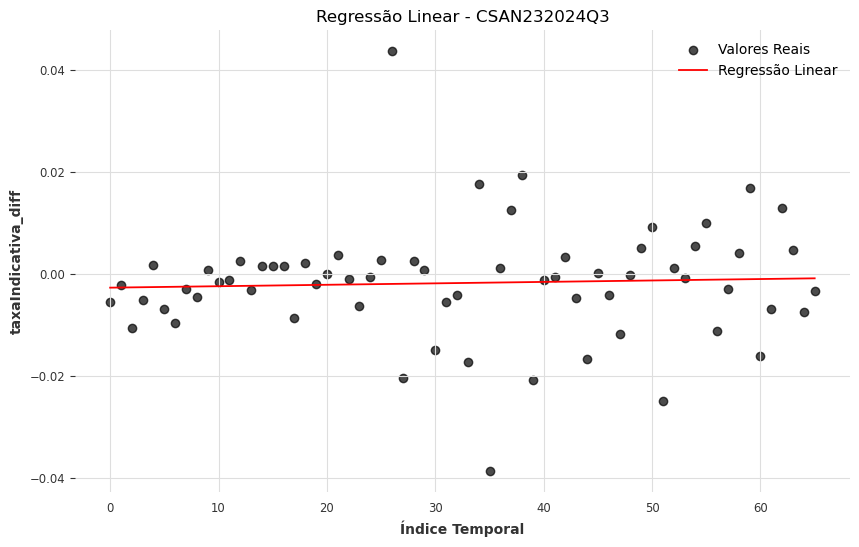

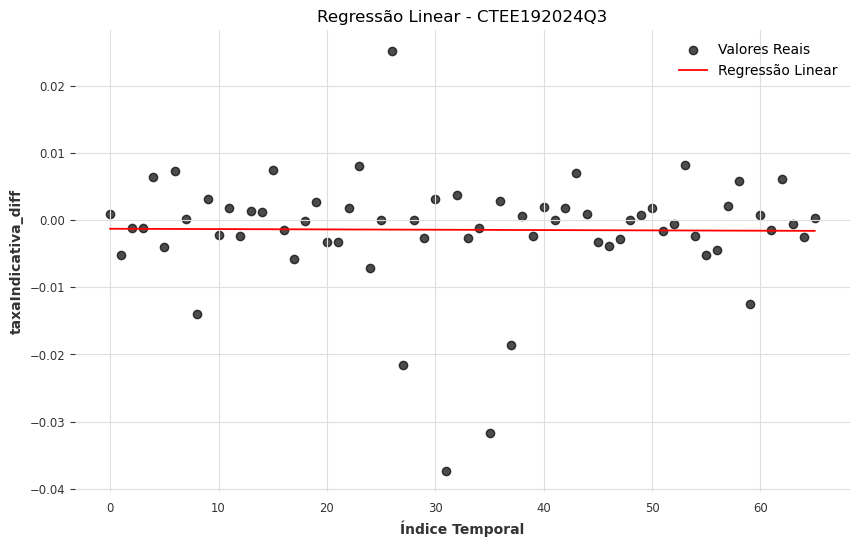

{'ALGA_MBM_2023Q3': {'coeficiente': 7.3800366300366e-05,
  'intercepto': -0.009615336538461507},
 'ALGA_MBM_2024Q3': {'coeficiente': 5.232856695543251e-05,
  'intercepto': -0.006724920850293969},
 'CSAN232024Q3': {'coeficiente': 2.81265003653059e-05,
  'intercepto': -0.0026292627770239507},
 'CTEE192024Q3': {'coeficiente': -4.822043628013735e-06,
  'intercepto': -0.0012614654002713673}}

In [20]:
from sklearn.linear_model import LinearRegression

# Realizar a regressão linear e plotar gráficos para cada dataset
results = {}

for name, df in filtered_dataframes.items():
    # Preparar dados para regressão
    X = np.arange(len(df)).reshape(-1, 1)  # Índices temporais como variável independente
    y = df['taxaIndicativa_diff'].values   # Variável dependente
    
    # Modelo de regressão linear
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    
    # Armazenar resultados
    results[name] = {
        'coeficiente': model.coef_[0],
        'intercepto': model.intercept_
    }
    
    # Plotar gráfico
    plt.figure(figsize=(10, 6))
    plt.scatter(X, y, label='Valores Reais', alpha=0.7)
    plt.plot(X, y_pred, color='red', label='Regressão Linear')
    plt.title(f"Regressão Linear - {name}")
    plt.xlabel("Índice Temporal")
    plt.ylabel("taxaIndicativa_diff")
    plt.legend()
    plt.show()

results

# Decomposição de série temporal

## 1 - Remoção da tendência

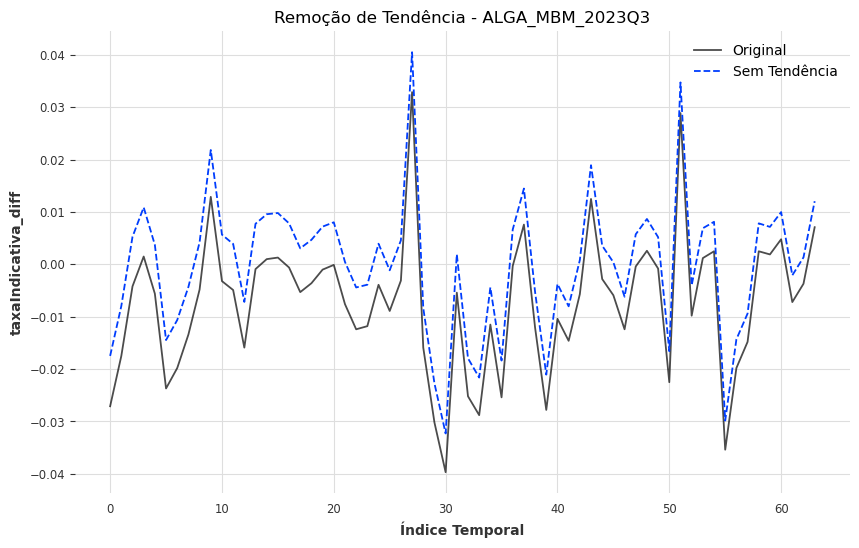

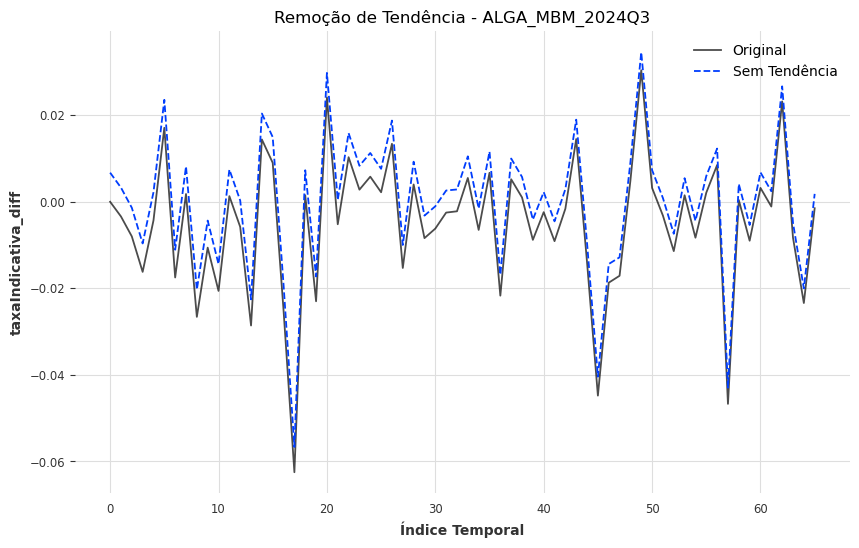

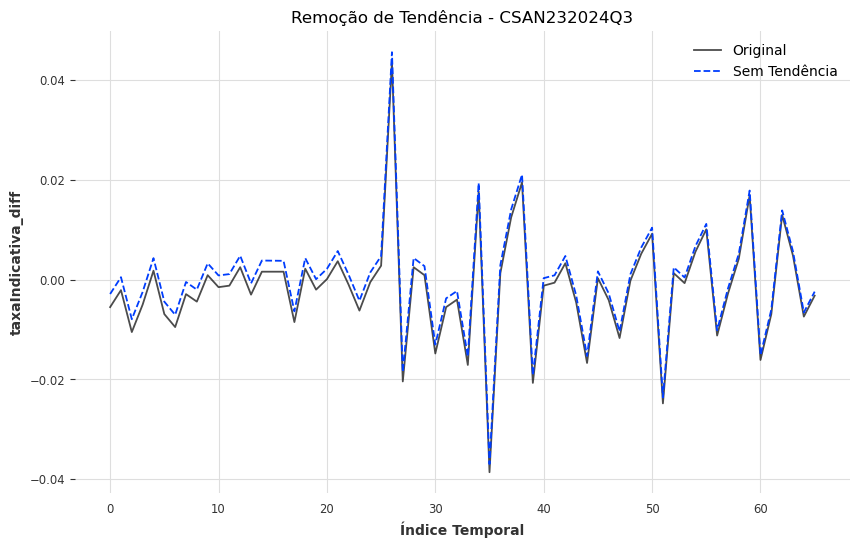

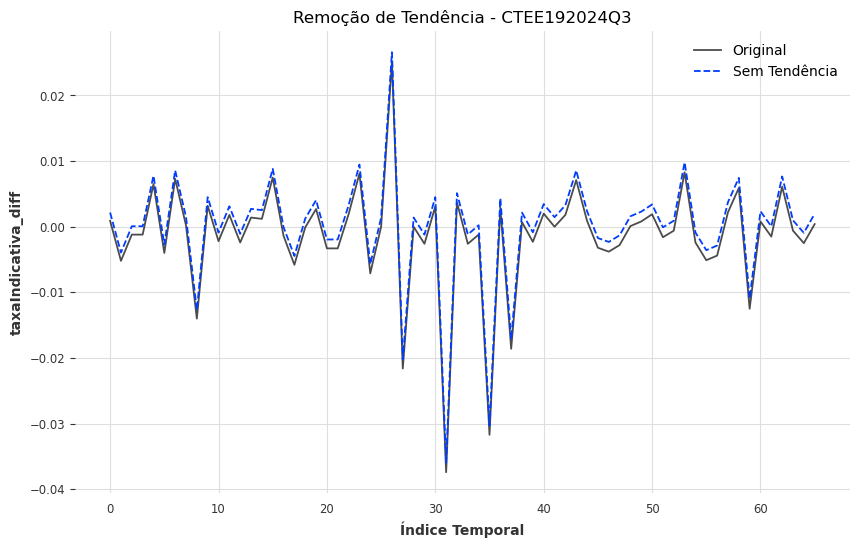

In [4]:
# Remoção de tendência e plotagem dos gráficos
for name, df in filtered_dataframes.items():
    # Remover tendência usando o método detrend
    df['taxaIndicativa_detrended'] = detrend(df['taxaIndicativa_diff'].values)
    
    # Plotar o gráfico
    plt.figure(figsize=(10, 6))
    plt.plot(df['taxaIndicativa_diff'], label='Original', alpha=0.7)
    plt.plot(df['taxaIndicativa_detrended'], label='Sem Tendência', linestyle='--')
    plt.title(f"Remoção de Tendência - {name}")
    plt.xlabel("Índice Temporal")
    plt.ylabel("taxaIndicativa_diff")
    plt.legend()
    plt.show()

## 2- Remover a sazonalidade 

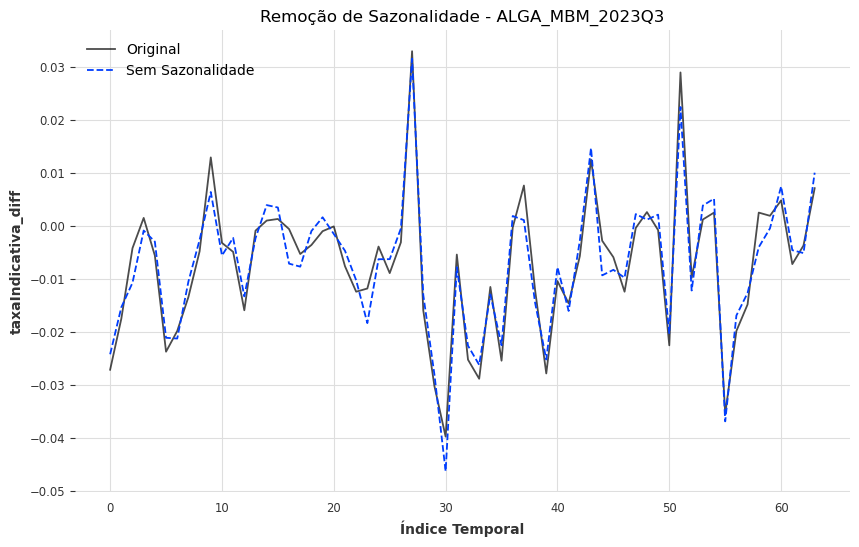

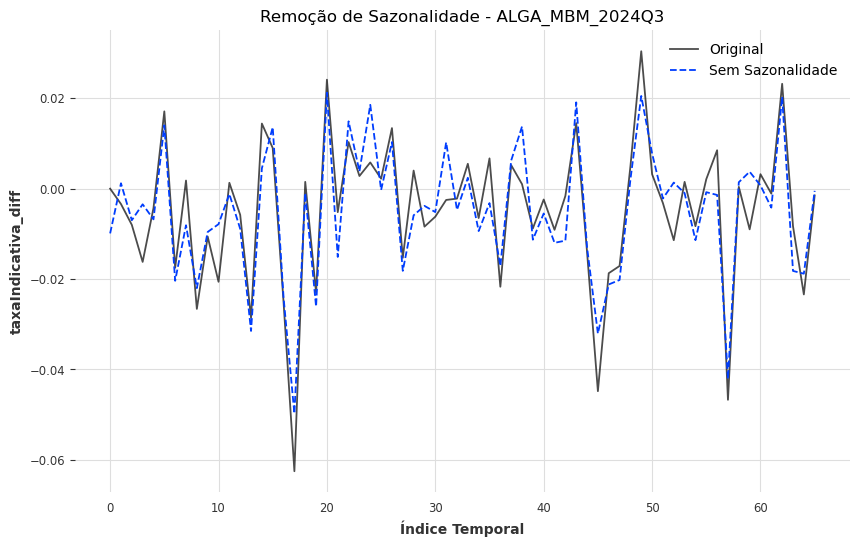

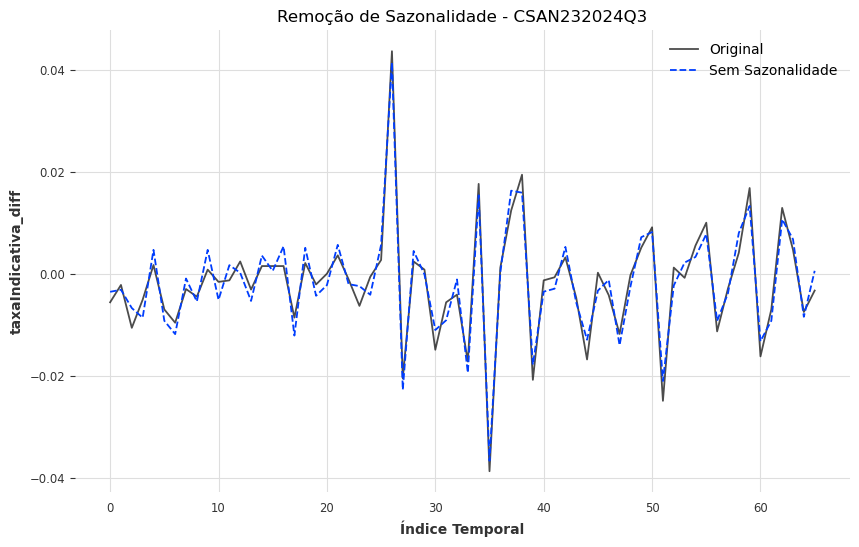

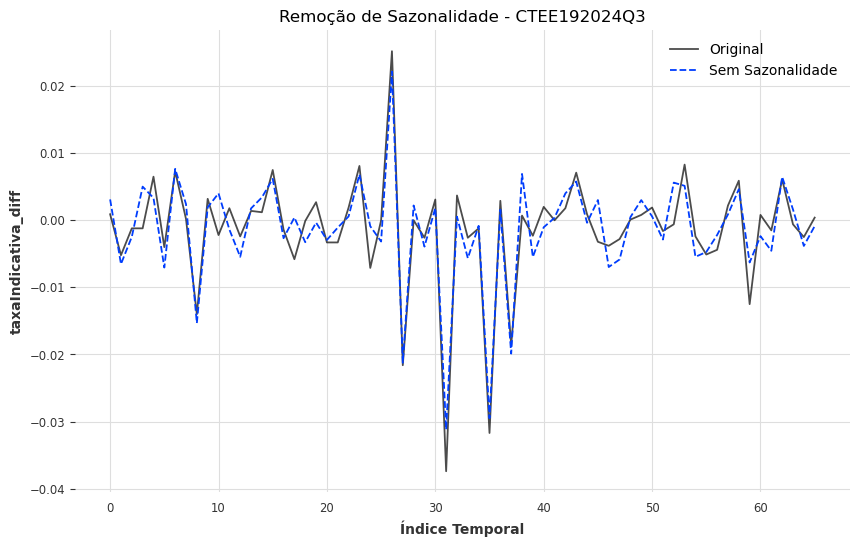

In [5]:
# Remover sazonalidade dos dados e plotar gráficos
for name, df in filtered_dataframes.items():
    # Tentar decomposição apenas em datasets grandes o suficiente
    if len(df) > 10:  # Necessário para aplicar decomposição
        # Criar uma série temporal indexada
        series = df['taxaIndicativa_diff']
        
        # Aplicar decomposição aditiva assumindo periodicidade (seasonal=7 para semanal)
        decomposition = seasonal_decompose(series, model='additive', period=7, extrapolate_trend='freq')
        
        # Remover a sazonalidade
        df['taxaIndicativa_no_season'] = series - decomposition.seasonal
        
        # Plotar gráfico
        plt.figure(figsize=(10, 6))
        plt.plot(series, label='Original', alpha=0.7)
        plt.plot(df['taxaIndicativa_no_season'], label='Sem Sazonalidade', linestyle='--')
        plt.title(f"Remoção de Sazonalidade - {name}")
        plt.xlabel("Índice Temporal")
        plt.ylabel("taxaIndicativa_diff")
        plt.legend()
        plt.show()
    else:
        print(f"Dataset {name} é muito pequeno para decomposição sazonal.")



## 3- Remover a autocorrelação utilizando o ARIMA

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-360.372, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-353.733, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-361.313, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-359.452, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-359.702, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-363.449, Time=0.07 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-355.881, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-363.440, Time=0.10 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-357.944, Time=0.04 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-353.788, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-365.319, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-367.251, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-369.249, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : 

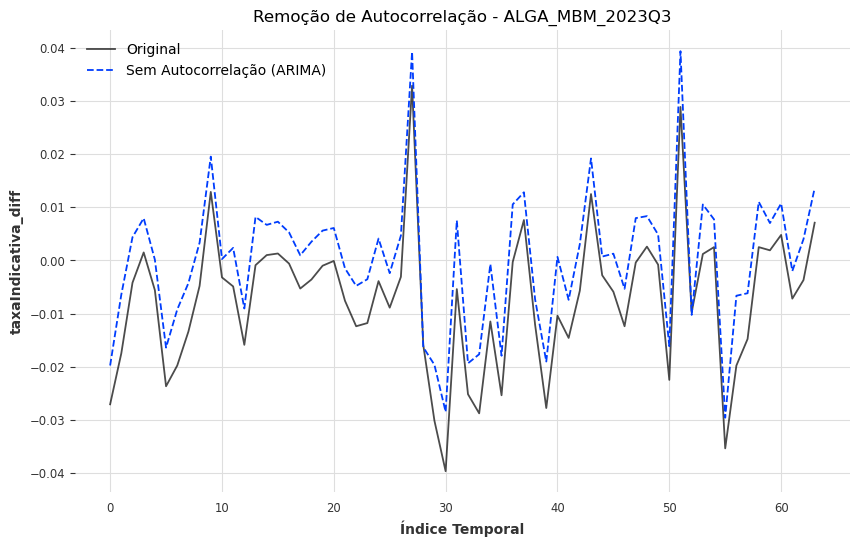

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-346.129, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-351.494, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-349.905, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-349.845, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-348.007, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-355.816, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-353.830, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-353.830, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-351.816, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.234 seconds


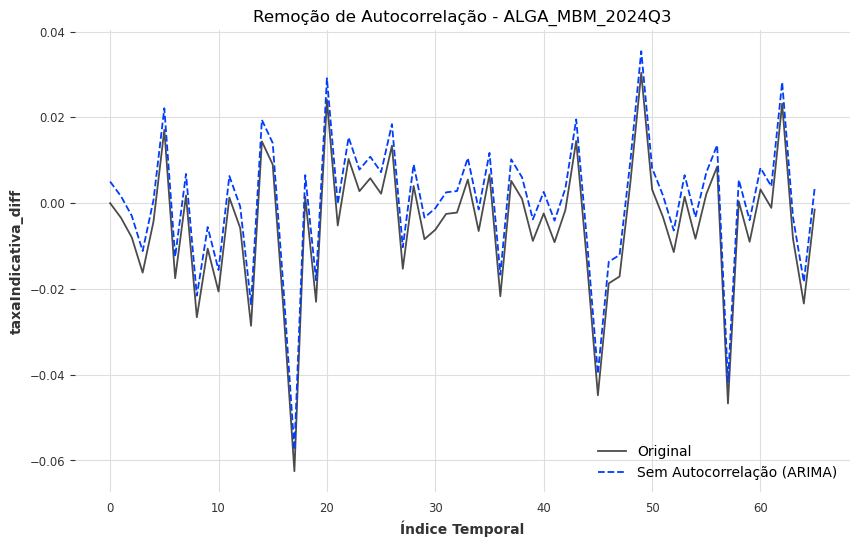

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-402.027, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-401.898, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-403.505, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-404.643, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-402.775, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-402.856, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-400.657, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-406.094, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-401.423, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-403.603, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-404.658, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-403.953, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-402.681, Time=0.08 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.517 seconds


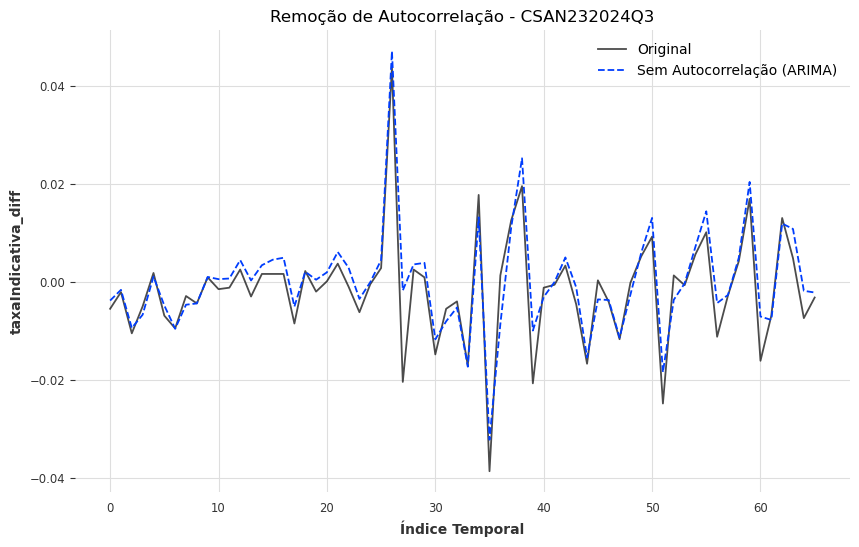

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-436.105, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-437.291, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-438.859, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-438.116, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-437.124, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-437.204, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-437.154, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-439.845, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-437.077, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-437.875, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-437.887, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-439.239, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-435.877, Time=0.17 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.547 seconds


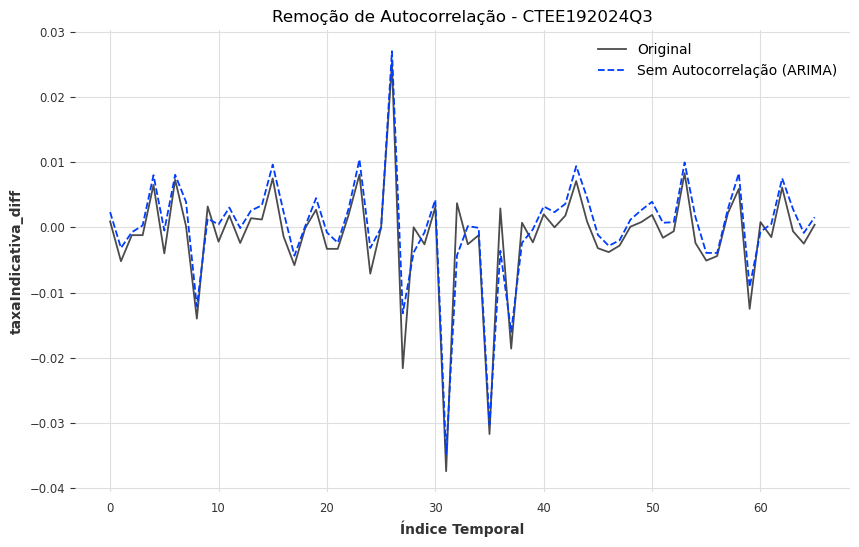

{'ALGA_MBM_2023Q3': <class 'statsmodels.iolib.summary.Summary'>
 """
                                SARIMAX Results                                
 Dep. Variable:                      y   No. Observations:                   64
 Model:               SARIMAX(0, 0, 1)   Log Likelihood                 187.625
 Date:                Tue, 17 Dec 2024   AIC                           -369.249
 Time:                        17:53:14   BIC                           -362.773
 Sample:                             0   HQIC                          -366.698
                                  - 64                                         
 Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 intercept     -0.0073      0.002     -3.715      0.000      -0.011      -0.003
 ma.L1          0.1972      0.118      1.666      0

In [6]:
from pmdarima import auto_arima

# Dicionário para armazenar os melhores modelos ARIMA
best_models = {}

# Aplicar Auto ARIMA e remover a autocorrelação
for name, df in filtered_dataframes.items():
    series = df['taxaIndicativa_diff']
    
    # Executar Auto ARIMA
    model = auto_arima(series, seasonal=False, trace=True, suppress_warnings=True, stepwise=True)
    best_models[name] = model.summary()
    
    # Previsões com o modelo
    fitted_values = model.predict_in_sample()
    residuals = series - fitted_values
    
    # Adicionar os resíduos (série sem autocorrelação)
    df['taxaIndicativa_no_autocorr'] = residuals
    
    # Plotar os gráficos
    plt.figure(figsize=(10, 6))
    plt.plot(series, label='Original', alpha=0.7)
    plt.plot(residuals, label='Sem Autocorrelação (ARIMA)', linestyle='--')
    plt.title(f"Remoção de Autocorrelação - {name}")
    plt.xlabel("Índice Temporal")
    plt.ylabel("taxaIndicativa_diff")
    plt.legend()
    plt.show()

best_models


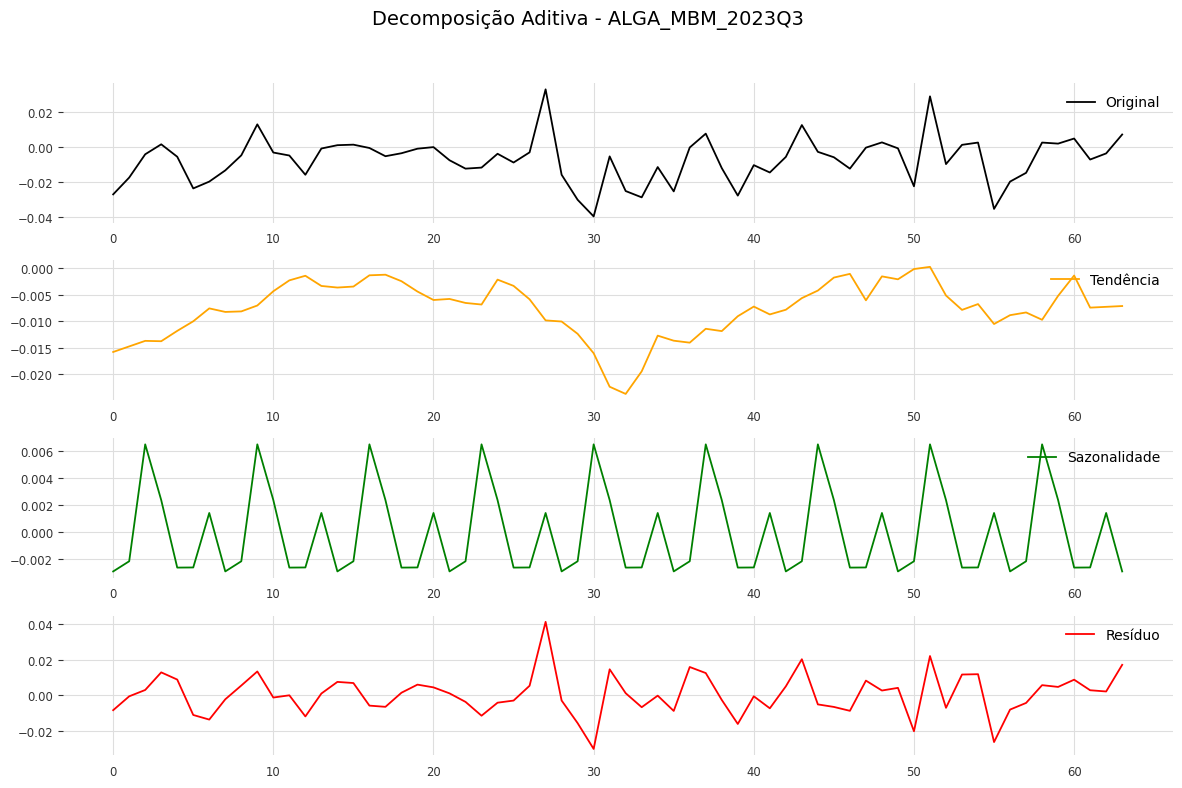

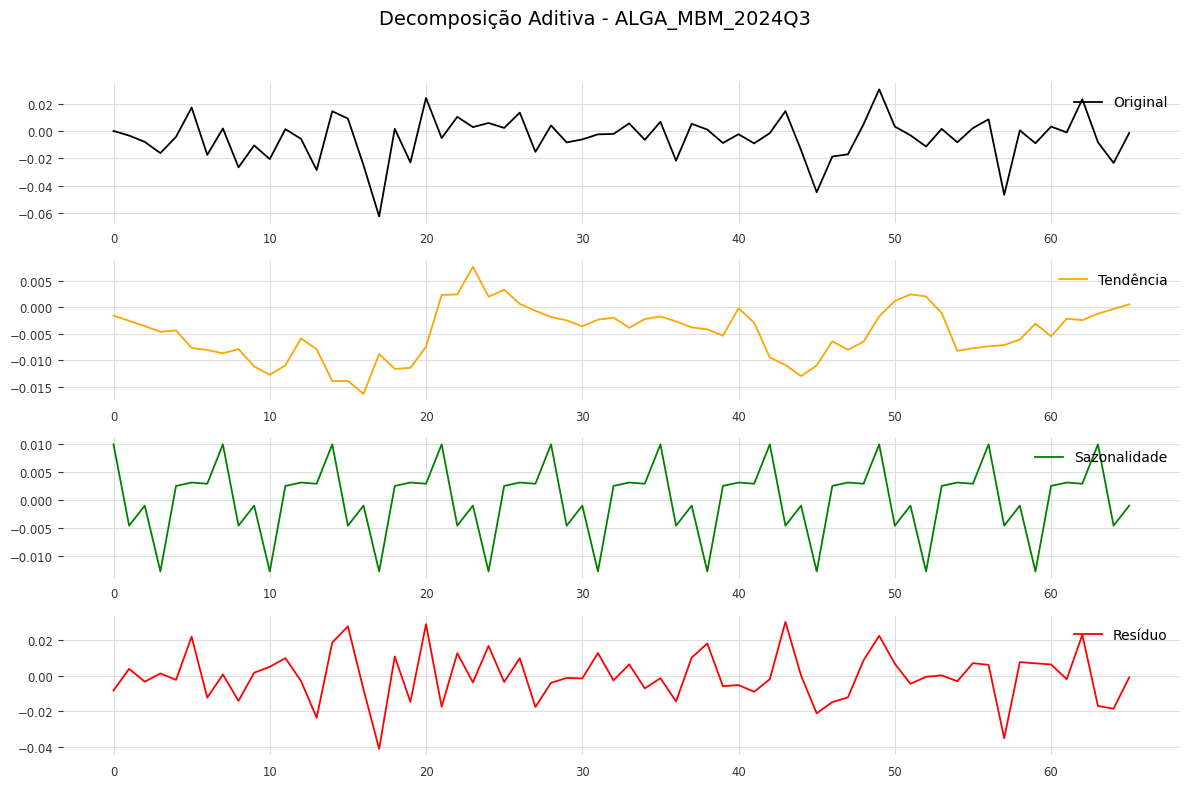

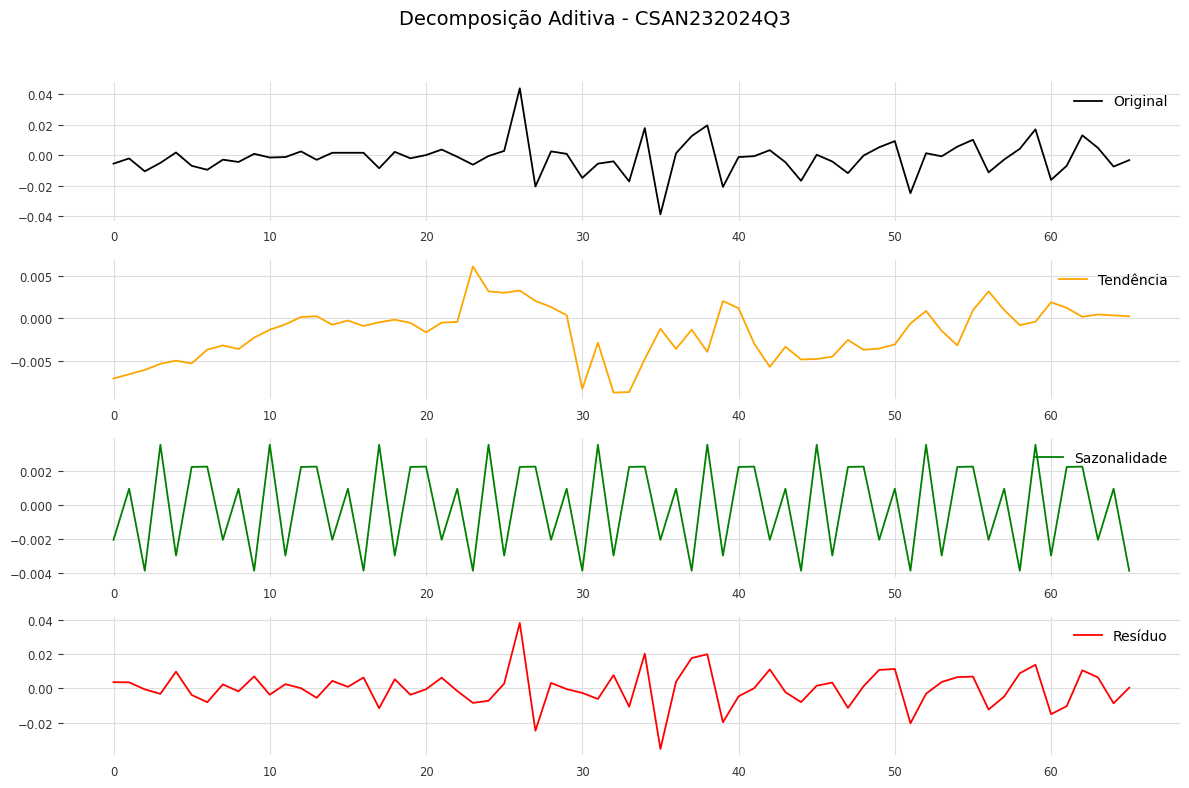

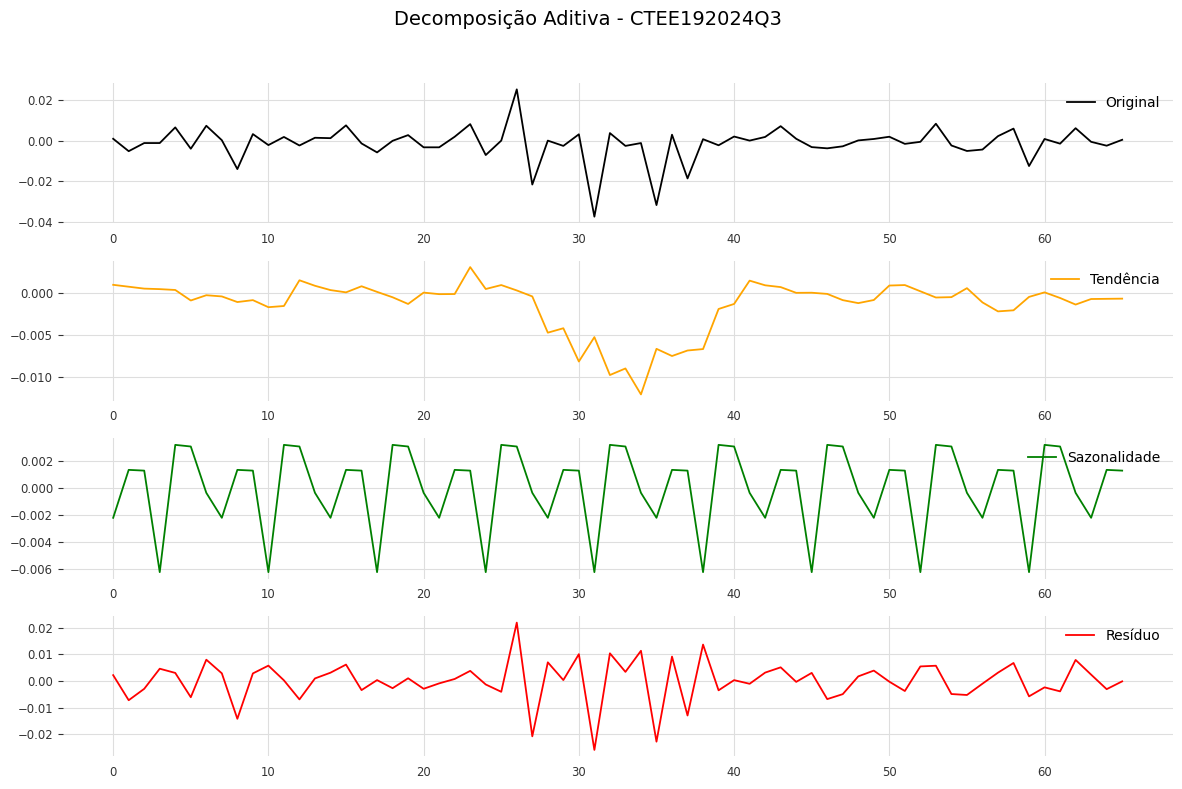

In [8]:
# Decomposição aditiva e plotagem para cada série
for name, df in filtered_dataframes.items():
    series = df['taxaIndicativa_diff']
    
    if len(series) > 10:  # Verificação para séries com tamanho suficiente
        # Aplicar decomposição Aditiva
        decomposition = seasonal_decompose(series, model='additive', period=7, extrapolate_trend='freq')
        
        # Plotar os componentes da decomposição
        plt.figure(figsize=(12, 8))
        plt.suptitle(f"Decomposição Aditiva - {name}", fontsize=14)
        
        # Série Original
        plt.subplot(4, 1, 1)
        plt.plot(series, label='Original')
        plt.legend(loc='upper right')
        
        # Tendência
        plt.subplot(4, 1, 2)
        plt.plot(decomposition.trend, label='Tendência', color='orange')
        plt.legend(loc='upper right')
        
        # Sazonalidade
        plt.subplot(4, 1, 3)
        plt.plot(decomposition.seasonal, label='Sazonalidade', color='green')
        plt.legend(loc='upper right')
        
        # Resíduos
        plt.subplot(4, 1, 4)
        plt.plot(decomposition.resid, label='Resíduo', color='red')
        plt.legend(loc='upper right')
        
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()
    else:
        print(f"Dataset {name} é muito pequeno para decomposição.")


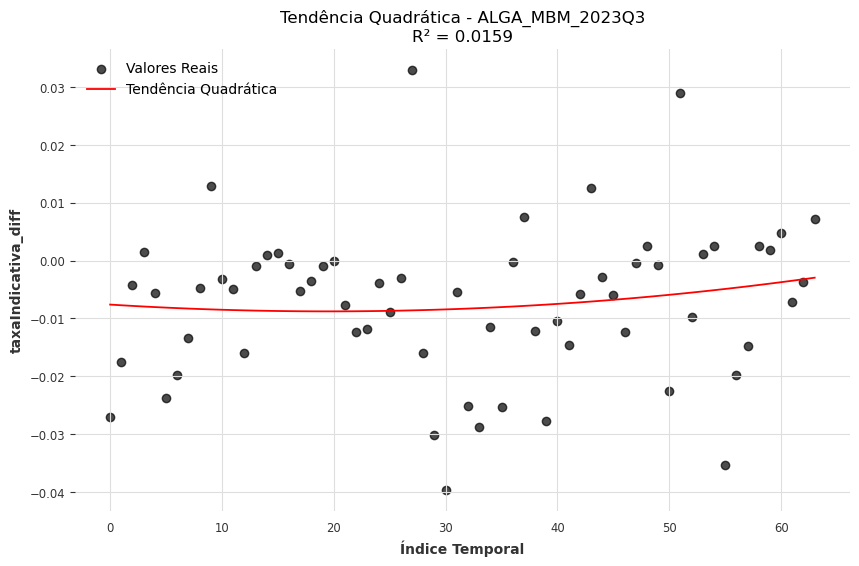

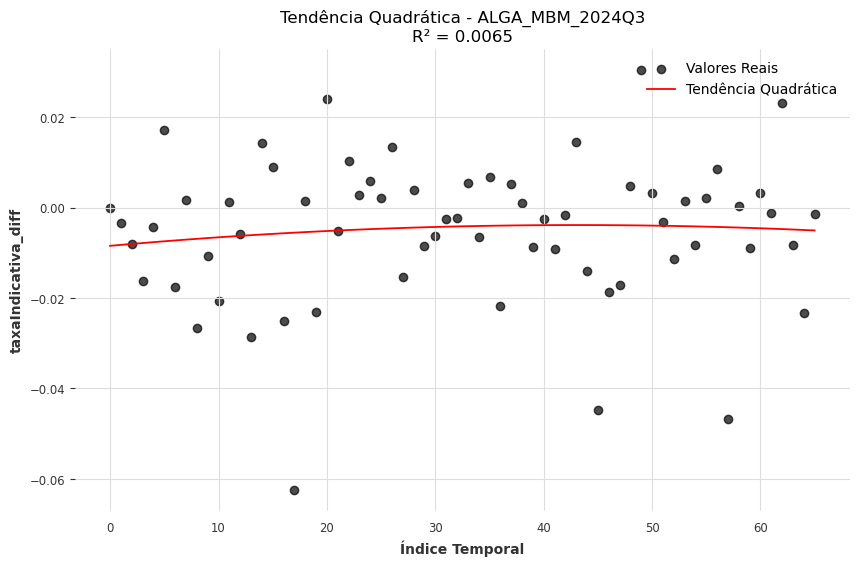

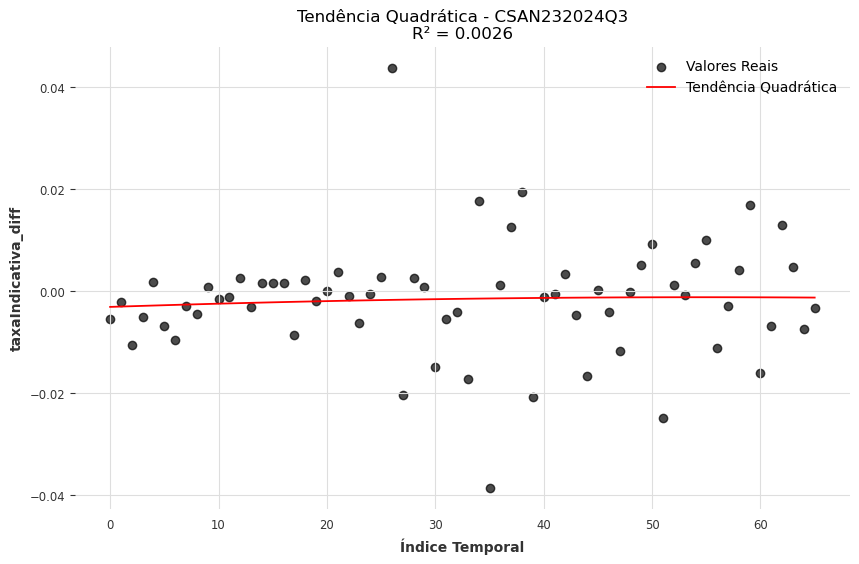

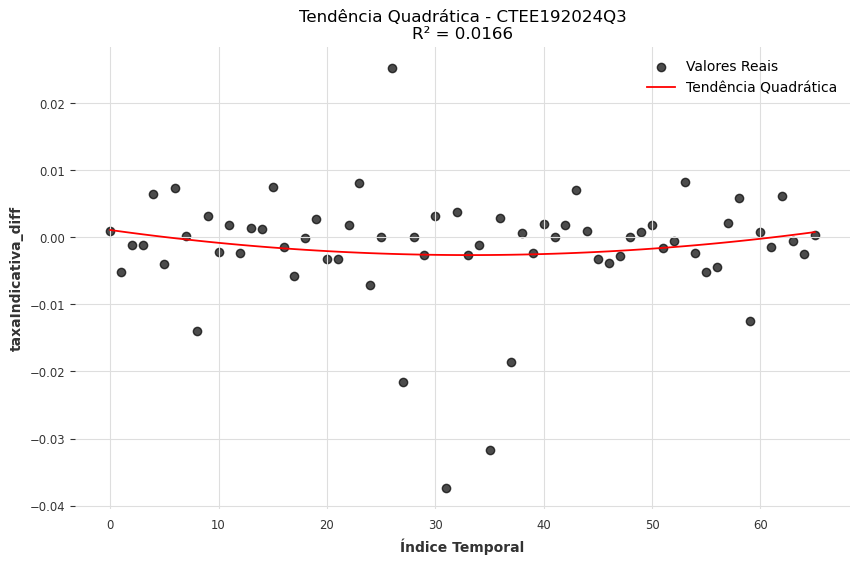

{'ALGA_MBM_2023Q3': {'R²': 0.015881569927137962,
  'Coeficientes': array([ 0.00000000e+00, -1.20122344e-04,  3.07813826e-06]),
  'Intercepto': -0.007611468531468446},
 'ALGA_MBM_2024Q3': {'R²': 0.006531672963547619,
  'Coeficientes': array([ 0.00000000e+00,  2.13374939e-04, -2.47763650e-06]),
  'Intercepto': -0.008442748822731211},
 'CSAN232024Q3': {'R²': 0.0026208338397021302,
  'Coeficientes': array([ 0.00000000e+00,  6.94955242e-05, -6.36446521e-07]),
  'Intercepto': -0.0030705323649133816},
 'CTEE192024Q3': {'R²': 0.016625078386102388,
  'Coeficientes': array([ 0.00000000e+00, -2.25193282e-04,  3.39032675e-06]),
  'Intercepto': 0.0010891611461409348}}

In [9]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Dicionário para armazenar os resultados do teste de tendência quadrática
quadratic_trend_results = {}

# Testar tendência quadrática para cada série
for name, df in filtered_dataframes.items():
    series = df['taxaIndicativa_diff']
    X = np.arange(len(series)).reshape(-1, 1)  # Índice temporal como variável independente
    y = series.values  # Valores da série
    
    # Transformar os dados para um polinômio de grau 2
    poly = PolynomialFeatures(degree=2)
    X_poly = poly.fit_transform(X)
    
    # Ajustar o modelo de regressão linear para os dados transformados
    model = LinearRegression()
    model.fit(X_poly, y)
    y_pred = model.predict(X_poly)
    
    # Calcular R² para avaliar a qualidade do ajuste
    r2 = r2_score(y, y_pred)
    quadratic_trend_results[name] = {'R²': r2, 'Coeficientes': model.coef_, 'Intercepto': model.intercept_}
    
    # Plotar os resultados
    plt.figure(figsize=(10, 6))
    plt.scatter(X, y, label='Valores Reais', alpha=0.7)
    plt.plot(X, y_pred, color='red', label='Tendência Quadrática')
    plt.title(f"Tendência Quadrática - {name}\nR² = {r2:.4f}")
    plt.xlabel("Índice Temporal")
    plt.ylabel("taxaIndicativa_diff")
    plt.legend()
    plt.show()

quadratic_trend_results


In [ ]:
#Criar uma nova 

In [10]:

# Aplicar diferenciação às variáveis 'spread_bid_ask', 'spread' e 'spread_2'
for name, df in dataframes.items():
    for col in ['spread_bid_ask', 'spread', 'spread_2']:
        if col in df.columns:
            df[f'{col}_diff'] = df[col].diff()

# Verificar as primeiras linhas das séries atualizadas
{ name: df[['spread_bid_ask_diff', 'spread_diff', 'spread_2_diff']].head() for name, df in dataframes.items() }


{'ALGA_MBM_2023Q3':    spread_bid_ask_diff  spread_diff  spread_2_diff
 0                  NaN          NaN            NaN
 1              -0.0887      -0.0712        -0.0887
 2               0.0257       0.0299         0.0257
 3               0.0178       0.0163         0.0178
 4               0.0024       0.0080         0.0024,
 'ALGA_MBM_2024Q3':    spread_bid_ask_diff  spread_diff  spread_2_diff
 0                  NaN          NaN            NaN
 1               0.0382       0.0416         0.0382
 2               0.0327       0.0407         0.0327
 3              -0.0590      -0.0428        -0.0590
 4               0.0035       0.0078         0.0035,
 'CSAN232024Q3':    spread_bid_ask_diff  spread_diff  spread_2_diff
 0                  NaN          NaN            NaN
 1               0.0422       0.0443         0.0422
 2              -0.0697      -0.0592        -0.0697
 3               0.0299       0.0349         0.0299
 4              -0.0270      -0.0288        -0.0270,
 'CTEE1

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Dicionário para armazenar os resultados da regressão
regression_results_diff = {}

# Variáveis independentes
features_diff = ['spread_bid_ask_diff', 'spread_diff', 'spread_2_diff']

# Realizar regressão linear multivariada para cada série
for name, df in dataframes.items():
    # Filtrar linhas sem valores nulos nas variáveis selecionadas
    data = df.dropna(subset=['taxaIndicativa_diff'] + features_diff)
    
    if not data.empty:  # Verificar se o dataset possui dados após remoção de nulos
        # Definir X e y
        X = data[features_diff]
        y = data['taxaIndicativa_diff']
        
        # Ajustar o modelo de regressão linear
        model = LinearRegression()
        model.fit(X, y)
        
        # Previsões e R²
        y_pred = model.predict(X)
        r2 = r2_score(y, y_pred)
        
        # Armazenar os resultados
        regression_results_diff[name] = {
            'Coeficientes': dict(zip(features_diff, model.coef_)),
            'Intercepto': model.intercept_,
            'R²': r2
        }

regression_results_diff


{'ALGA_MBM_2023Q3': {'Coeficientes': {'spread_bid_ask_diff': 0.33434909479893254,
   'spread_diff': -0.9999999999999973,
   'spread_2_diff': 0.6656509052010647},
  'Intercepto': 2.6020852139652106e-18,
  'R²': 1.0},
 'ALGA_MBM_2024Q3': {'Coeficientes': {'spread_bid_ask_diff': 0.12013527151416474,
   'spread_diff': -0.9999999999999981,
   'spread_2_diff': 0.8798647284858334},
  'Intercepto': 2.6020852139652106e-18,
  'R²': 1.0},
 'CSAN232024Q3': {'Coeficientes': {'spread_bid_ask_diff': 0.6738105647007449,
   'spread_diff': -0.999999999999995,
   'spread_2_diff': 0.3261894352992511},
  'Intercepto': -1.734723475976807e-18,
  'R²': 1.0},
 'CTEE192024Q3': {'Coeficientes': {'spread_bid_ask_diff': 0.9617319146721925,
   'spread_diff': -0.9999999999999963,
   'spread_2_diff': 0.03826808532780425},
  'Intercepto': 2.168404344971009e-19,
  'R²': 1.0}}

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Criar um dicionário para armazenar resultados
model_results = {}

# Rodar o modelo para cada série
for name, df in dataframes.items():
    print(f"\nRodando regressão linear para a série: {name}")
    
    # Selecionar apenas linhas sem valores nulos
    data = df.dropna(subset=['taxaIndicativa_diff', 'spread_bid_ask_diff', 'spread_diff', 'spread_2_diff'])
    
    if not data.empty:  # Garantir que haja dados suficientes
        # Definir variáveis independentes (X) e dependente (y)
        X = data[['spread_bid_ask_diff', 'spread_diff', 'spread_2_diff']]
        y = data['taxaIndicativa_diff']
        
        # Dividir em treino e teste
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Ajustar o modelo
        model = LinearRegression()
        model.fit(X_train, y_train)
        
        # Fazer previsões
        y_pred = model.predict(X_test)
        
        # Calcular métricas
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        # Armazenar os resultados
        model_results[name] = {
            'R²': r2,
            'RMSE': rmse,
            'Coeficientes': dict(zip(X.columns, model.coef_)),
            'Intercepto': model.intercept_
        }
        
        # Exibir resultados
        print(f"R²: {r2:.4f}, RMSE: {rmse:.4f}")
        print("Coeficientes:", dict(zip(X.columns, model.coef_)))
        print("Intercepto:", model.intercept_)
    else:
        print(f"A série {name} não possui dados suficientes após a limpeza.")

# Exibir todos os resultados
print("\nResultados finais para todas as séries:")
for series, result in model_results.items():
    print(f"\nSérie: {series}")
    for key, value in result.items():
        print(f"{key}: {value}")



Rodando regressão linear para a série: ALGA_MBM_2023Q3
R²: 1.0000, RMSE: 0.0000
Coeficientes: {'spread_bid_ask_diff': 0.2754874677609703, 'spread_diff': -0.9999999999999963, 'spread_2_diff': 0.7245125322390273}
Intercepto: -1.5612511283791264e-17

Rodando regressão linear para a série: ALGA_MBM_2024Q3
R²: 1.0000, RMSE: 0.0000
Coeficientes: {'spread_bid_ask_diff': 0.1293268857414617, 'spread_diff': -0.9999999999999973, 'spread_2_diff': 0.8706731142585353}
Intercepto: -9.974659986866641e-18

Rodando regressão linear para a série: CSAN232024Q3
R²: 1.0000, RMSE: 0.0000
Coeficientes: {'spread_bid_ask_diff': 0.6614977916153303, 'spread_diff': -0.9999999999999959, 'spread_2_diff': 0.33850220838466627}
Intercepto: 3.469446951953614e-18

Rodando regressão linear para a série: CTEE192024Q3
R²: 1.0000, RMSE: 0.0000
Coeficientes: {'spread_bid_ask_diff': 0.9035217258313257, 'spread_diff': -0.999999999999997, 'spread_2_diff': 0.09647827416867115}
Intercepto: 6.071532165918825e-18

Resultados finais

## Realizar a previsao da série temporal utilizando o Auto ARIMA

In [27]:
# Criar as variáveis diferenciadas para 'spread_bid_ask', 'spread', 'spread_2'
for name, df in dataframes.items():
    for col in ['spread_bid_ask', 'spread', 'spread_2']:
        if col in df.columns:
            df[f'{col}_diff'] = df[col].diff()

# Analisar a performance das variáveis independentes com regressão linear univariada
variable_performance = {}

for name, df in dataframes.items():
    print(f"\nAnalisando variáveis independentes para a série: {name}")
    # Limpar dados: remover linhas com valores nulos
    data = df.dropna(subset=['taxaIndicativa_diff', 'spread_bid_ask_diff', 'spread_diff', 'spread_2_diff'])
    
    if not data.empty:
        y = data['taxaIndicativa_diff']  # Variável dependente
        variable_results = {}
        
        # Testar cada variável independente isoladamente
        for col in ['spread_bid_ask_diff', 'spread_diff', 'spread_2_diff']:
            X = data[[col]]
            model = LinearRegression()
            model.fit(X, y)
            y_pred = model.predict(X)
            r2 = r2_score(y, y_pred)
            variable_results[col] = r2
        
        # Armazenar os resultados
        variable_performance[name] = variable_results
        
        # Mostrar os resultados para a série atual
        for var, score in variable_results.items():
            print(f"R² para {var}: {score:.4f}")
    else:
        print(f"A série {name} não possui dados suficientes após limpeza.")

# Exibir os resultados finais
print("\nResultados finais:")
for series, results in variable_performance.items():
    print(f"\nSérie: {series}")
    for var, score in results.items():
        print(f"{var}: R² = {score:.4f}")



Analisando variáveis independentes para a série: ALGA_MBM_2023Q3
R² para spread_bid_ask_diff: 0.0162
R² para spread_diff: 0.0827
R² para spread_2_diff: 0.0162

Analisando variáveis independentes para a série: ALGA_MBM_2024Q3
R² para spread_bid_ask_diff: 0.0169
R² para spread_diff: 0.0826
R² para spread_2_diff: 0.0169

Analisando variáveis independentes para a série: CSAN232024Q3
R² para spread_bid_ask_diff: 0.2455
R² para spread_diff: 0.0149
R² para spread_2_diff: 0.2455

Analisando variáveis independentes para a série: CTEE192024Q3
R² para spread_bid_ask_diff: 0.0489
R² para spread_diff: 0.0331
R² para spread_2_diff: 0.0489

Resultados finais:

Série: ALGA_MBM_2023Q3
spread_bid_ask_diff: R² = 0.0162
spread_diff: R² = 0.0827
spread_2_diff: R² = 0.0162

Série: ALGA_MBM_2024Q3
spread_bid_ask_diff: R² = 0.0169
spread_diff: R² = 0.0826
spread_2_diff: R² = 0.0169

Série: CSAN232024Q3
spread_bid_ask_diff: R² = 0.2455
spread_diff: R² = 0.0149
spread_2_diff: R² = 0.2455

Série: CTEE192024Q3
s

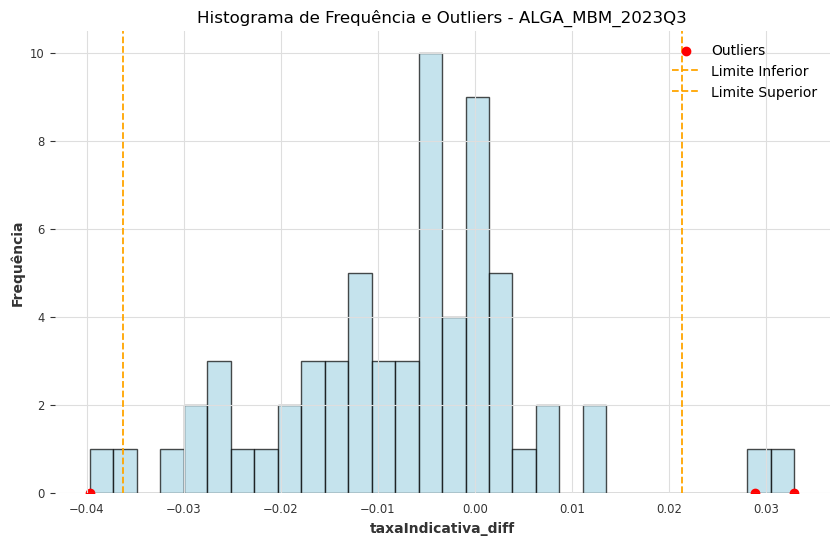

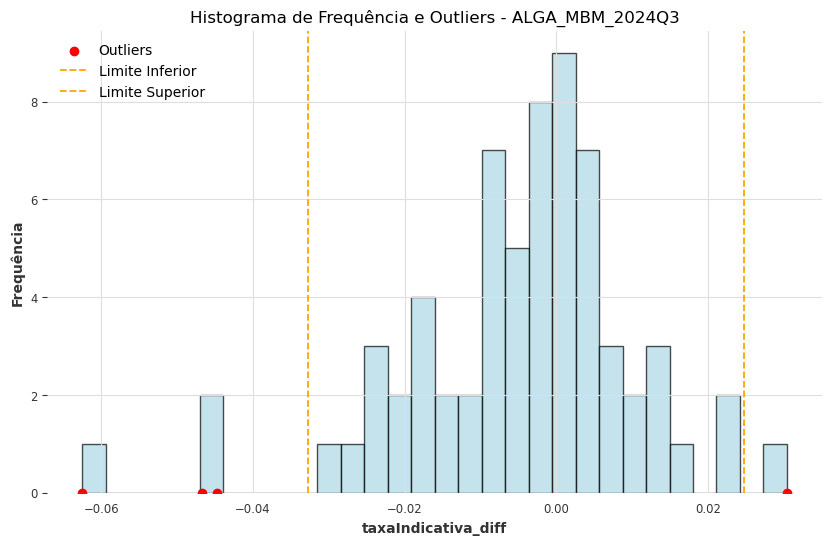

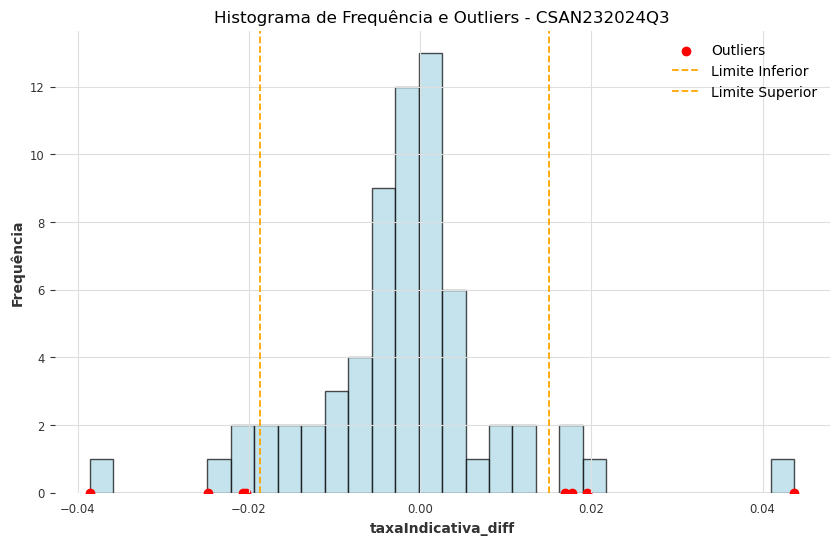

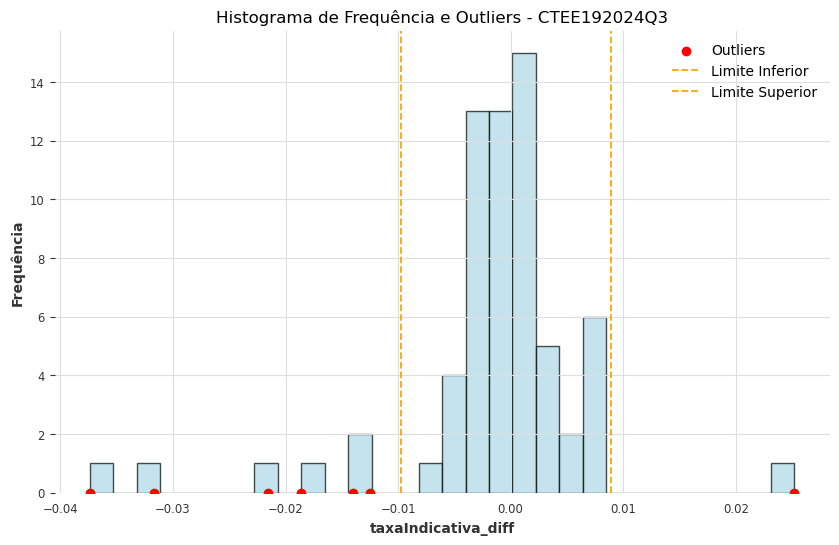

In [21]:
# Realizar o histograma de Frequência para cada dataset
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Função para identificar outliers usando IQR
def identify_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = series[(series < lower_bound) | (series > upper_bound)]
    return outliers, lower_bound, upper_bound

# Carregar os datasets para inspecionar a estrutura
dataframes = {name: pd.read_csv(path) for name, path in files.items()}

# Gerar histogramas e detectar outliers
for name, df in dataframes.items():
    if 'taxaIndicativa_diff' in df.columns:
        series = df['taxaIndicativa_diff'].dropna()
        outliers, lower, upper = identify_outliers(series)
        
        # Plotar o histograma
        plt.figure(figsize=(10, 6))
        plt.hist(series, bins=30, color='lightblue', edgecolor='black', alpha=0.7)
        plt.scatter(outliers, np.zeros_like(outliers), color='red', label='Outliers')
        plt.axvline(lower, color='orange', linestyle='--', label='Limite Inferior')
        plt.axvline(upper, color='orange', linestyle='--', label='Limite Superior')
        plt.title(f"Histograma de Frequência e Outliers - {name}")
        plt.xlabel("taxaIndicativa_diff")
        plt.ylabel("Frequência")
        plt.legend()
        plt.show()


## Encontrado que o modelo que melhor se adapta é o SARIMAX (2,0,1)

                               SARIMAX Results                                
Dep. Variable:         taxaIndicativa   No. Observations:                   64
Model:               SARIMAX(2, 0, 1)   Log Likelihood                 174.878
Date:                Tue, 17 Dec 2024   AIC                           -341.756
Time:                        23:50:22   BIC                           -333.120
Sample:                             0   HQIC                          -338.354
                                 - 64                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0576      0.196      0.294      0.768      -0.326       0.441
ar.L2          0.9422      0.196      4.814      0.000       0.559       1.326
ma.L1          0.9994      3.935      0.254      0.8

c:\Users\miche\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


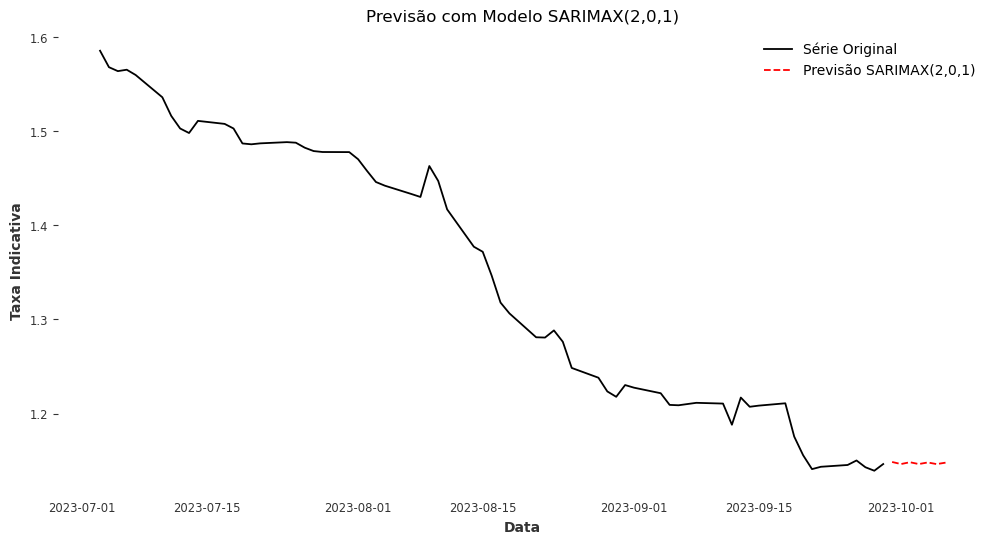

In [37]:
# Importar bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Remover valores nulos da variável tacaIndicativa_difff
df_valid = df.dropna(subset=['taxaIndicativa_diff'])

# Ajustar o modelo SARIMAX(5,0,0)
model_sarimax = SARIMAX(df_valid['taxaIndicativa'], order=(2, 0, 1), seasonal_order=(0, 0, 0, 0))
model_fit = model_sarimax.fit()

# Exibir o resumo do modelo
print(model_fit.summary())

# Fazer previsões para os próximos 7 períodos
n_periods = 7
forecast = model_fit.forecast(steps=n_periods)

# Criar datas futuras para a previsão
forecast_dates = pd.date_range(df_valid['dataReferencia'].iloc[-1], periods=n_periods + 1, freq='D')[1:]

# Plotar a série original e as previsões
plt.figure(figsize=(12, 6))
plt.plot(df_valid['dataReferencia'], df_valid['taxaIndicativa'], label='Série Original')
plt.plot(forecast_dates, forecast, label='Previsão SARIMAX(2,0,1)', color='red', linestyle='--')
plt.title('Previsão com Modelo SARIMAX(2,0,1)')
plt.xlabel('Data')
plt.ylabel('Taxa Indicativa')
plt.legend()
plt.grid()
plt.show()


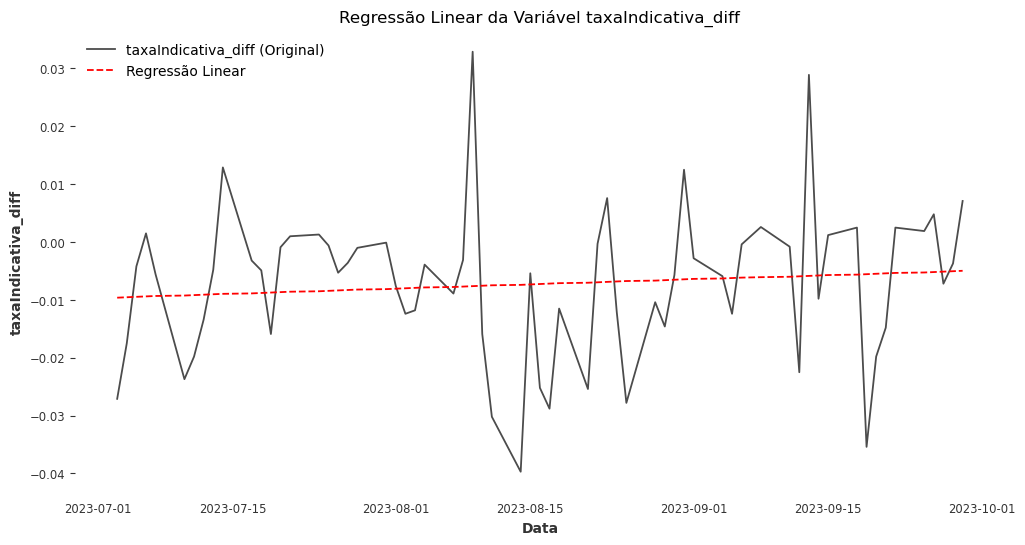

(7.3800366300366e-05, -0.009615336538461507, 0.010770279560696872)

In [39]:
# Remover valores nulos da variável tacaIndicativa_difff
df_valid = df_valid.dropna(subset=['taxaIndicativa_diff'])

# Preparar dados para regressão
x = np.arange(len(df_valid)).reshape(-1, 1)  # Variável independente: tempo
y = df_valid['taxaIndicativa_diff'].values.reshape(-1, 1)  # Variável dependente: taxaIndicativa_diff

# Ajustar o modelo de regressão linear
model = LinearRegression()
model.fit(x, y)

# Prever os valores ajustados
y_pred = model.predict(x)

# Plotar os resultados
plt.figure(figsize=(12, 6))
plt.plot(df_valid['dataReferencia'], y, label='taxaIndicativa_diff (Original)', alpha=0.7)
plt.plot(df_valid['dataReferencia'], y_pred, label='Regressão Linear', color='red', linestyle='--')
plt.title('Regressão Linear da Variável taxaIndicativa_diff')
plt.xlabel('Data')
plt.ylabel('taxaIndicativa_diff')
plt.legend()
plt.grid()
plt.show()

# Coeficientes da regressão
slope = model.coef_[0][0]
intercept = model.intercept_[0]
r_squared = model.score(x, y)

slope, intercept, r_squared


## Realziar o Split Mensal do Dataset

In [48]:
# Criar uma nova coluna 'AnoMes' para agrupar por ano e mês
#df['AnoMes'] = df['dataReferencia'].dt.to_period('M')

# Criar um diretório para salvar as séries mensais
#output_dir = "series_mensais"
#os.makedirs(output_dir, exist_ok=True)

# Iterar pelos meses únicos e salvar cada subconjunto em um arquivo CSV
#for period, group in df.groupby('AnoMes'):
#    output_file = os.path.join(output_dir, f"ALGA_MBM_{period}.csv")
#    group.to_csv(output_file, index=False)
#    print(f"Série mensal salva: {output_file}")


Série mensal salva: series_mensais\ALGA_MBM_2023-01.csv
Série mensal salva: series_mensais\ALGA_MBM_2023-02.csv
Série mensal salva: series_mensais\ALGA_MBM_2023-03.csv
Série mensal salva: series_mensais\ALGA_MBM_2023-04.csv
Série mensal salva: series_mensais\ALGA_MBM_2023-05.csv
Série mensal salva: series_mensais\ALGA_MBM_2023-06.csv
Série mensal salva: series_mensais\ALGA_MBM_2023-07.csv
Série mensal salva: series_mensais\ALGA_MBM_2023-08.csv
Série mensal salva: series_mensais\ALGA_MBM_2023-09.csv
Série mensal salva: series_mensais\ALGA_MBM_2023-10.csv
Série mensal salva: series_mensais\ALGA_MBM_2023-11.csv
Série mensal salva: series_mensais\ALGA_MBM_2023-12.csv
Série mensal salva: series_mensais\ALGA_MBM_2024-01.csv
Série mensal salva: series_mensais\ALGA_MBM_2024-02.csv
Série mensal salva: series_mensais\ALGA_MBM_2024-03.csv
Série mensal salva: series_mensais\ALGA_MBM_2024-04.csv
Série mensal salva: series_mensais\ALGA_MBM_2024-05.csv
Série mensal salva: series_mensais\ALGA_MBM_2024

## Realizar o Split Trimestral da base de dados

In [28]:
# Criar uma nova coluna 'AnoTrimestre' para agrupar por trimestre
df['AnoTrimestre'] = df['dataReferencia'].dt.to_period('Q')  # Q = Trimestre

# Criar um diretório para salvar as séries trimestrais
output_dir = "series_trimestrais"
#os.makedirs(output_dir, exist_ok=True)

# Iterar pelos trimestres únicos e salvar cada subconjunto em um arquivo CSV
for period, group in df.groupby('AnoTrimestre'):
    output_file = os.path.join(output_dir, f"CTEE19{period}.csv")
    group.to_csv(output_file, index=False)
    print(f"Série trimestral salva: {output_file}")


Série trimestral salva: series_trimestrais\CTEE192023Q1.csv
Série trimestral salva: series_trimestrais\CTEE192023Q2.csv
Série trimestral salva: series_trimestrais\CTEE192023Q3.csv
Série trimestral salva: series_trimestrais\CTEE192023Q4.csv
Série trimestral salva: series_trimestrais\CTEE192024Q1.csv
Série trimestral salva: series_trimestrais\CTEE192024Q2.csv
Série trimestral salva: series_trimestrais\CTEE192024Q3.csv
Série trimestral salva: series_trimestrais\CTEE192024Q4.csv


# Contar quantos registro tem no arquivo series_trimestrais\ALGA_MBM_2024Q4.csv

In [29]:
#contar quantos registro tem no arquivo series_trimestrais\ALGA_MBM_2024Q4.csv
# Carregar o dataset
#file_path = "series_trimestrais\CTEE192024Q3.csv"
#df = pd.read_csv(file_path)
#print(f"Total de registros no arquivo {file_path}: {df.shape[0]}")
# Remover o ano dos registros de dataReferencia e colocar numa nova coluna chamada ano
#df['ano'] = df['dataReferencia'].dt.year
# Remover o ano dos registros no campo dataReferencia
#df['dataReferencia'] = df['dataReferencia'].dt.strftime('%m-%d')
# Guardar no arquivo CSV


Total de registros no arquivo series_trimestrais\CTEE192024Q3.csv: 66


### Previsao dos ultimos 7 dias baseados em 3 meses

c:\Users\miche\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


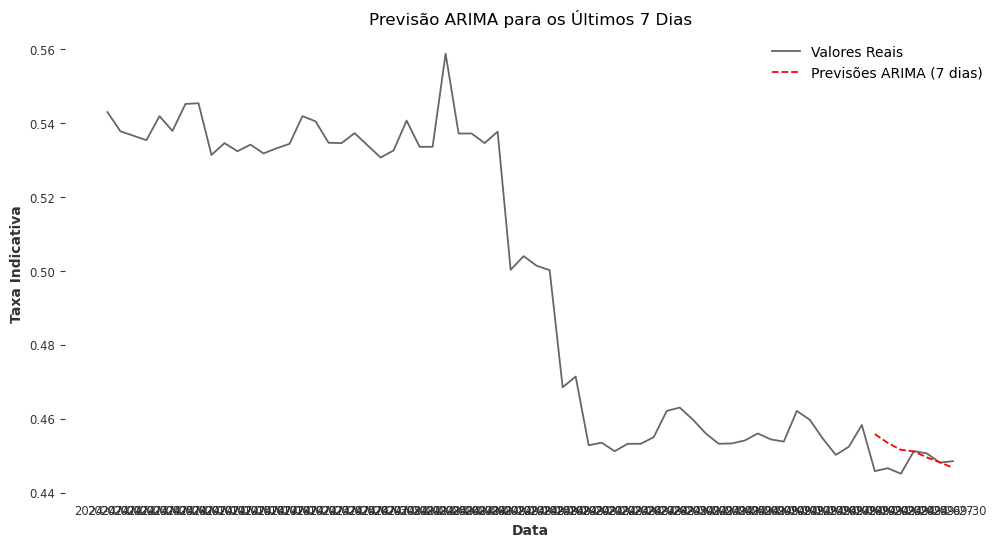

          Data  Valores Reais  Previsões
59  2024-09-20         0.4458   0.455819
60  2024-09-23         0.4466   0.453433
61  2024-09-24         0.4451   0.451567
62  2024-09-25         0.4512   0.451150
63  2024-09-26         0.4506   0.449524
64  2024-09-27         0.4481   0.448194
65  2024-09-30         0.4485   0.446707


In [ ]:
# Importação de bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA


#
# Filtrar apenas a série diferenciada (ignorar o primeiro valor NaN da diferenciação)
df_diff = df.dropna(subset=['taxaIndicativa_diff']).reset_index(drop=True)

# Dividir os dados: treino (22 primeiros dias) e teste (7 dias seguintes)
train = df_diff.iloc[:59]
test = df_diff.iloc[59:66]

# Treinar o modelo ARIMA
model = ARIMA(train['taxaIndicativa_diff'], order=(3, 0, 2))  # Ordem ARIMA pode ser ajustada
model_fit = model.fit()

# Fazer previsões para os próximos 7 dias
forecast = model_fit.forecast(steps=len(test))

# Reintegrar a série diferenciada para compará-la com os valores reais
# Somar os valores previstos cumulativamente ao último valor da série original de treino
forecast_reintegrated = np.cumsum(forecast) + train['taxaIndicativa'].iloc[-1]

# Preparar os valores reais da série original
real_values = test['taxaIndicativa']

# Criar datas para as previsões
forecast_dates = test['dataReferencia']

# Plotar os resultados
plt.figure(figsize=(12, 6))
plt.plot(df['dataReferencia'], df['taxaIndicativa'], label='Valores Reais', alpha=0.6)
plt.plot(forecast_dates, forecast_reintegrated, label='Previsões ARIMA (7 dias)', color='red', linestyle='--')
plt.title('Previsão ARIMA para os Últimos 7 Dias')
plt.xlabel('Data')
plt.ylabel('Taxa Indicativa')
plt.legend()
plt.grid()
plt.show()

# Exibir previsões e valores reais
forecast_results = pd.DataFrame({
    'Data': forecast_dates,
    'Valores Reais': real_values.values,
    'Previsões': forecast_reintegrated.values
})
print(forecast_results)


In [ ]:
# Função para identificar outliers usando IQR
def identify_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = series[(series < lower_bound) | (series > upper_bound)]
    return outliers, lower_bound, upper_bound

dataframes = {name: pd.read_csv(path) for name, path in files.items()}

# Gerar histogramas e detectar outliers
for name, df in dataframes.items():
    if 'taxaIndicativa_diff' in df.columns:
        series = df['taxaIndicativa_diff'].dropna()
        outliers, lower, upper = identify_outliers(series)
        
     


### Aplicando a biblioteca SKTIME no modelo de previsão para os proximos 3 dias

### Rodar uma analise de correlacao entre as variaveis dentro do titulo ALGA28

# Professor Michel
#### Aplicar todas as diferenciaoes possiveis (ao menos 3) e verificar qual apresenta uma estacionaridade melhor

+ Remover a tendencia
+ Remover a sazonalidade
+ Remover a autocorrelacao
+ colocarr a base logaritmica (Se tiver uma tendencia exponencial)
+ Aplicar a transformacao de raiz quadrada (Se tiver uma tendencia quadratica)
+ Dado essa serie aplique Dick Fuller, e trace a media da curva.
+ Fica de olho no resultado do P valor do teste em relacao a cada um dos modelos acima.

#### Passo 2 => Olhar visualmente e pelo teste cada uma das series e na sequencia aplicar o modelo preditivo quais(todos ensinados pela Paloma), 
### aplicar a regressao classica na serie mais estacionaria.

# Heitor
+ Dentro da série diferenciada. Realizar uma distribuição num histograma de grequencia para verificar se a distribuição é normal.
+ Fazer  o previsto contra o realizado pra diversas datas.
+ Varios gráficos de 22 dias
+ Retirar os dados antes de 2023


## Professor Michel

- Trocar ativos 3 ativos distintos
- Regressao linear com os labels
- Regressao linera multivariada
- Serie temporal multivariada


In [44]:
#Aplicar todas as diferenciaoes possiveis (ao menos 3) e verificar qual apresenta uma estacionaridade melhor

#Remover a tendencia
#Remover a sazonalidade
#Remover a autocorrelacao
#colocarr a base logaritmica (Se tiver uma tendencia exponencial)
#Aplicar a transformacao de raiz quadrada (Se tiver uma tendencia quadratica)
#Dado essa serie aplique Dick Fuller, e trace a media da curva.
#Fica de olho no resultado do P valor do teste em relacao a cada um dos modelos acima.

#Passo 2 => Olhar visualmente e pelo teste cada uma das series e na sequencia aplicar o modelo preditivo quais(todos ensinados pela Paloma), 
# aplicar a regressao classica na serie mais estacionaria.

In [45]:
#remover a tendencia da variavel temporal taxaIndicativa
